# **Setting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from torchsummary import summary
import time
import copy

import random

import os

In [ ]:
!pip install timm

In [4]:
from torchvision import datasets as ds
from torch.utils.data import DataLoader
from torchvision import transforms as ts
import torchvision as tv
import torch
import torch.nn as nn
import math
import numpy as np
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn
import timm
from PIL import Image
from tqdm import tqdm
import random
import os

%config Completer.use_jedi = False

In [5]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(config.seed)

In [6]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

device

device(type='cuda')

# **Dataset**

In [7]:
transform  = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

vaildset = torchvision.datasets.CIFAR10(root='/data',
                                        train=False,
                                        download=True,
                                        transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
testset = torchvision.datasets.ImageFolder(root = "./drive/MyDrive/Statistical_Deep_Image",
                                           transform = transform)

In [10]:
train_loader = DataLoader(trainset,
                          batch_size = 32,
                          shuffle=True,
                          num_workers=2)

vaild_loader = DataLoader(vaildset,
                          batch_size = 32,
                          shuffle=True,
                          num_workers=2)


test_loader = DataLoader(testset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=2)

# **Model**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_bn(inp, oup, stride, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 3, stride, 1, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


def conv_1x1_bn(inp, oup, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 1, 1, 0, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


class Hswish(nn.Module):
    def __init__(self, inplace=True):
        super(Hswish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3., inplace=self.inplace) / 6.


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3., inplace=self.inplace) / 6.


class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            Hsigmoid()
            # nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Identity(nn.Module):
    def __init__(self, channel):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class MobileBottleneck(nn.Module):
    def __init__(self, inp, oup, kernel, stride, exp, se=False, nl='RE'):
        super(MobileBottleneck, self).__init__()
        assert stride in [1, 2]
        assert kernel in [3, 5]
        padding = (kernel - 1) // 2
        self.use_res_connect = stride == 1 and inp == oup

        conv_layer = nn.Conv2d
        norm_layer = nn.BatchNorm2d
        if nl == 'RE':
            nlin_layer = nn.ReLU # or ReLU6
        elif nl == 'HS':
            nlin_layer = Hswish
        else:
            raise NotImplementedError
        if se:
            SELayer = SEModule
        else:
            SELayer = Identity

        self.conv = nn.Sequential(
            # pw
            conv_layer(inp, exp, 1, 1, 0, bias=False),
            norm_layer(exp),
            nlin_layer(inplace=True),
            # dw
            conv_layer(exp, exp, kernel, stride, padding, groups=exp, bias=False),
            norm_layer(exp),
            SELayer(exp),
            nlin_layer(inplace=True),
            # pw-linear
            conv_layer(exp, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, n_class=1000, input_size=224, dropout=0.8, mode='small', width_mult=1.0):
        super(MobileNetV3, self).__init__()
        input_channel = 3
        last_channel = 1280
        if mode == 'large':
            # refer to Table 1 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  False, 'RE', 1],
                [3, 64,  24,  False, 'RE', 2],
                [3, 72,  24,  False, 'RE', 1],
                [5, 72,  40,  True,  'RE', 2],
                [5, 120, 40,  True,  'RE', 1],
                [5, 120, 40,  True,  'RE', 1],
                [3, 240, 80,  False, 'HS', 2],
                [3, 200, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 480, 112, True,  'HS', 1],
                [3, 672, 112, True,  'HS', 1],
                [5, 672, 160, True,  'HS', 2],
                [5, 960, 160, True,  'HS', 1],
                [5, 960, 160, True,  'HS', 1],
            ]
        elif mode == 'small':
            # refer to Table 2 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  True,  'RE', 2],
                [3, 72,  24,  False, 'RE', 2],
                [3, 88,  24,  False, 'RE', 1],
                [5, 96,  40,  True,  'HS', 2],
                [5, 240, 40,  True,  'HS', 1],
                [5, 240, 40,  True,  'HS', 1],
                [5, 120, 48,  True,  'HS', 1],
                [5, 144, 48,  True,  'HS', 1],
                [5, 288, 96,  True,  'HS', 2],
                [5, 576, 96,  True,  'HS', 1],
                [5, 576, 96,  True,  'HS', 1],
            ]
        else:
            raise NotImplementedError

        # building first layer
        assert input_size % 32 == 0
        last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2, nlin_layer=Hswish)]
        self.classifier = []

        # building mobile blocks
        for k, exp, c, se, nl, s in mobile_setting:
            output_channel = make_divisible(c * width_mult)
            exp_channel = make_divisible(exp * width_mult)
            self.features.append(MobileBottleneck(input_channel, output_channel, k, s, exp_channel, se, nl))
            input_channel = output_channel

        # building last several layers
        if mode == 'large':
            last_conv = make_divisible(960 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        elif mode == 'small':
            last_conv = make_divisible(576 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            # self.features.append(SEModule(last_conv))  # refer to paper Table2, but I think this is a mistake
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        else:
            raise NotImplementedError

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),    # refer to paper section 6
            nn.Linear(last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


In [12]:
model = MobileNetV3(n_class=10,input_size=32)

In [13]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 16, 16]              81
       BatchNorm2d-2            [-1, 3, 16, 16]               6
            Hswish-3            [-1, 3, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]              48
       BatchNorm2d-5           [-1, 16, 16, 16]              32
              ReLU-6           [-1, 16, 16, 16]               0
            Conv2d-7             [-1, 16, 8, 8]             144
       BatchNorm2d-8             [-1, 16, 8, 8]              32
 AdaptiveAvgPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                    [-1, 4]              64
             ReLU-11                    [-1, 4]               0
           Linear-12                   [-1, 16]              64
         Hsigmoid-13                   [-1, 16]               0
         SEModule-14             [-1, 1

In [14]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [15]:
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_loader,
    'val_dl':vaild_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models_mobileNetV3/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models_mobileNetV3')

In [16]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/29, current lr= 0.01
Copied best model weights!
train loss: 4.068513, val loss: 5.394333, accuracy: 11.74, time: 1.2441 min
----------
Epoch 1/29, current lr= 0.01
Copied best model weights!
train loss: 3.707106, val loss: 2.737246, accuracy: 9.86, time: 2.6310 min
----------
Epoch 2/29, current lr= 0.01
Copied best model weights!
train loss: 4.898305, val loss: 2.331896, accuracy: 13.57, time: 3.8899 min
----------
Epoch 3/29, current lr= 0.01
Copied best model weights!
train loss: 2.294274, val loss: 2.321154, accuracy: 13.76, time: 5.1469 min
----------
Epoch 4/29, current lr= 0.01
Copied best model weights!
train loss: 2.291518, val loss: 2.301839, accuracy: 13.14, time: 6.3490 min
----------
Epoch 5/29, current lr= 0.01
train loss: 2.300501, val loss: 2.304320, accuracy: 9.96, time: 7.5669 min
----------
Epoch 6/29, current lr= 0.01
train loss: 2.306002, val loss: 2.309809, accuracy: 9.95, time: 8.7932 min
----------
Epoch 7/29, current lr= 0.01
train loss: 2.303902, val l

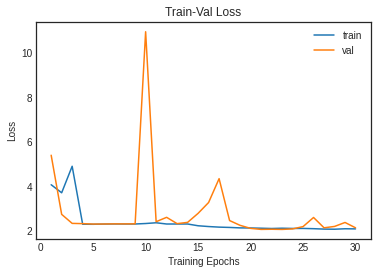

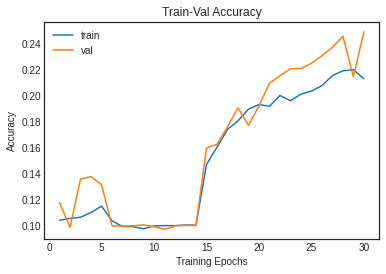

In [17]:
# Train-Validation progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [18]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hswish()
    )
    (1): MobileBottleneck(
      (conv): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            

In [19]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs= model(images)
      _, predicted = torch.max(outputs.data,1)
      total +=labels.size(0)
      correct += (predicted == labels).sum().item()

print(100* correct/total)

7.8
